# Zero-shot Multi-modal Integration with Pre-trained scGPT-spatial 

#### Dataset: Multi-modal Developing Fetal Lung (Visium/Xenium) ([Quach et al.](https://www.nature.com/articles/s41467-024-50281-5))

In this demo, we will explore the integration of two different types of spatial transcriptomics data modalities—10X Visium and Xenium—using the pre-trained scGPT-spatial model. The goal is to project shared genes between these two datasets and use scGPT-spatial's zero-shot embeddings for integrative clustering. Ideally, cells or spots would cluster according to biological states rather than by sequencing protocol. We will assess the biological conservation performance by comparing the clustering results to major cell-type labels.


✨ To get started, you will need to download the following:

   - [scGPT-spatial pretrained checkpoint](https://figshare.com/articles/software/scGPT-spatial_V1_Model_Weights/28356068?file=52163879) ✅

   - [Processed Developing Fetal Lung dataset](https://figshare.com/articles/dataset/_Evaluation_Processed_Multi-modal_Developing_Fetal_Lung_Data_Subset_Visium_Xenium_/28356116?file=52164002]), featuring a subset of Xenium and Visium data from GW15 ✅

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
#python -c "import flash_attn; print('Flash Attention installed successfully!')"
#module load  gcc/12.2.0

In [13]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import warnings
from matplotlib import pyplot as plt

from typing import Dict, Optional, Union
import torch
from tqdm import tqdm
from scipy.sparse import csr_matrix
import scib

sys.path.insert(0, "../")
import scgpt_spatial
from scgpt_spatial.utils import eval_scib_metrics
warnings.filterwarnings("ignore", category=ResourceWarning)

#### Step 1: Load dataset
Note that this demo dataset has been pre-processed and filtered to include only the shared genes between the GW15 Visium and Xenium samples published by Quach et al. Major cell class labels are aligned across Visium and Xenium by grouping the subtype annotations provided by the original authors.

In [14]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'cell_type_2'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [15]:
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'cell_type_2'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [16]:
adata.obs['celltype'] = adata.obs['cell_type']
adata.obs['batch_id'] = 'VisiumHD'

In [17]:
# Visium data contains stromal cells 
adata[adata.obs['batch_id']=='visium'].shape, adata[adata.obs['batch_id']=='visium'].obs.celltype.unique()

((0, 3333), [], Categories (0, object): [])

In [18]:
# Xenium data contains both stromal and epithelial cells 
adata[adata.obs['batch_id']=='xenium'].shape, adata[adata.obs['batch_id']=='xenium'].obs.celltype.unique()

((0, 3333), [], Categories (0, object): [])

#### Step 2: Run scGPT-spatial zero-shot inference 
Make sure all the downloaded `.json` and `.csv` files are also in the checkpoint folder - not just model weights!

You can simply call the `scgpt_spatial.tasks.embed_data()` function below to generate zero-shot embeddings for cells/spots.

In [19]:
model_dir = '/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-spatial/scGPT_spatial_v1'
gene_col = 'index'
cell_type_col = 'celltype'
batch_id_col = 'batch_id'

In [23]:
ref_embed_adata = scgpt_spatial.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_col, 
    batch_size=64,
    return_new_adata=True,
)
ref_embed_adata.obsm['X'] = ref_embed_adata.X.copy()
ref_embed_adata.obs['batch_id'] = adata.obs['batch_id']

2025-06-30 14:14:52,252 - jupyter_logger - INFO - match 3299/3333 genes in vocabulary of size 60697.
2025-06-30 14:14:52,597 - jupyter_logger - INFO - Loading parameter encoder.embedding.weight with shape torch.Size([60697, 512])


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


2025-06-30 14:14:52,597 - jupyter_logger - INFO - Loading parameter encoder.enc_norm.weight with shape torch.Size([512])
2025-06-30 14:14:52,598 - jupyter_logger - INFO - Loading parameter encoder.enc_norm.bias with shape torch.Size([512])
2025-06-30 14:14:52,598 - jupyter_logger - INFO - Loading parameter flag_encoder.weight with shape torch.Size([2, 512])
2025-06-30 14:14:52,598 - jupyter_logger - INFO - Loading parameter value_encoder.linear1.weight with shape torch.Size([512, 1])
2025-06-30 14:14:52,598 - jupyter_logger - INFO - Loading parameter value_encoder.linear1.bias with shape torch.Size([512])
2025-06-30 14:14:52,598 - jupyter_logger - INFO - Loading parameter value_encoder.linear2.weight with shape torch.Size([512, 512])
2025-06-30 14:14:52,599 - jupyter_logger - INFO - Loading parameter value_encoder.linear2.bias with shape torch.Size([512])
2025-06-30 14:14:52,599 - jupyter_logger - INFO - Loading parameter value_encoder.norm.weight with shape torch.Size([512])
2025-06-3

Embedding cells: 100%|██████████| 91/91 [00:04<00:00, 18.33it/s]
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [24]:
ref_embed_adata

AnnData object with n_obs × n_vars = 5778 × 512
    obs: 'celltype', 'batch_id'
    obsm: 'X'

In [25]:
embed_df = pd.DataFrame(ref_embed_adata.obsm['X'], index=ref_embed_adata.obs.index)
embed_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
NAME,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCTTG-1,0.015407,0.045282,-0.021229,-0.055420,0.007866,-0.034737,-0.000535,-0.006980,0.018526,0.059009,...,0.069328,-0.020650,0.009614,0.029924,0.021079,-0.008998,0.049861,0.016790,0.006116,-0.036071
AAACCCAAGTGGACGT-1,0.018441,0.048748,-0.014399,-0.034800,0.042728,-0.035859,-0.029757,-0.006242,-0.020392,0.042548,...,0.022681,-0.022319,0.014996,0.068029,-0.000587,0.009413,-0.008626,-0.016968,0.015649,-0.061908
AAACCCACAGAAGTGC-1,0.008843,0.052541,-0.002391,-0.049862,0.020148,-0.026730,0.003203,-0.006381,-0.017814,0.057778,...,0.019913,-0.021182,-0.013013,0.043009,0.003618,-0.005794,-0.006500,0.005943,0.021463,-0.068317
AAACCCAGTCATTGCA-1,0.024583,0.049152,-0.025769,-0.047381,0.028134,-0.027009,0.020178,-0.017742,-0.025701,0.043736,...,0.034215,-0.014696,-0.005062,0.062459,0.023497,0.018577,-0.006648,-0.005296,0.026158,-0.056661
AAACCCATCATCGCAA-1,0.038753,0.032202,-0.036378,-0.043935,0.012652,-0.037769,0.015740,-0.030416,-0.047009,0.033415,...,0.033097,-0.027315,-0.028279,0.053929,0.035998,0.015591,0.023280,0.007793,0.025128,-0.039946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGGGACTA-1,0.020635,0.044712,-0.013051,-0.055605,0.037706,-0.038751,-0.000545,-0.023106,-0.022184,0.041532,...,0.023862,-0.035471,-0.009690,0.050254,0.013346,0.000715,-0.008059,0.004202,0.024197,-0.066281
TTTGTTGCATTGTAGC-1,0.035772,0.048871,-0.042630,-0.039194,0.051869,-0.022998,-0.013055,0.019046,-0.005170,0.051652,...,0.024810,-0.037859,0.028317,0.080690,0.019579,-0.003632,-0.017386,-0.033694,-0.026859,-0.045309
TTTGTTGGTACCACGC-1,0.020297,0.059339,-0.042912,-0.044783,0.031556,-0.047768,0.016459,-0.021131,-0.049052,0.045901,...,0.028602,-0.044454,-0.013104,0.063706,0.019017,0.008046,-0.001613,-0.012641,0.041029,-0.056532


In [26]:
embed_df.to_parquet('/ix/djishnu/shared/djishnu_kor11/scGPT_outputs/tonsil_embeddings_spatial.parquet')

### Get gene embeddings

In [27]:
import sys
sys.path.append('/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-spatial/scgpt_spatial')
from tokenizer.gene_tokenizer import GeneVocab

vocab_file = '/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-spatial/scGPT_spatial_v1/vocab.json'
vocab = GeneVocab.from_file(vocab_file)

In [28]:
adata.var["id_in_vocab"] = [
        vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
    ]

In [29]:
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
gene_ids_in_vocab.shape

(3333,)

In [30]:
import json
model_config_file = '/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-spatial/scGPT_spatial_v1/args.json'
with open(model_config_file, "r") as f:
    model_configs = json.load(f)

In [40]:
from model import TransformerModel

model_file = '/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-spatial/scGPT_spatial_v1/best_model.pt'

In [41]:
use_fast_transformer = True
device = 'cuda:0'


def load_pretrained(
    model: torch.nn.Module,
    pretrained_params,
    strict: bool = False,
    prefix = None,
    verbose: bool = False,
) -> torch.nn.Module:
    """
    Load pretrained weights to the model.
    Args:
        model (torch.nn.Module): The model to load weights to.
        pretrained_params (Mapping[str, torch.Tensor]): The pretrained parameters.
        strict (bool): Whether to strictly enforce that the keys in :attr:`pretrained_params`
            match the keys returned by this module's :meth:`Module.state_dict`. Default to False.
        prefix (List[str]): The list of prefix strings to match with the keys in
            :attr:`pretrained_params`. The matched keys will be loaded. Default to None.
    Returns:
        torch.nn.Module: The model with pretrained weights.
    """
    use_flash_attn = getattr(model, "use_fast_transformer", True)
    if not use_flash_attn:
        pretrained_params = {
            k.replace("Wqkv.", "in_proj_"): v for k, v in pretrained_params.items()
        }
    if prefix is not None and len(prefix) > 0:
        if isinstance(prefix, str):
            prefix = [prefix]
        pretrained_params = {
            k: v
            for k, v in pretrained_params.items()
            if any(k.startswith(p) for p in prefix)
        }
    model_dict = model.state_dict()
    if strict:
        if verbose:
            for k, v in pretrained_params.items():
                logger.info(f"Loading parameter {k} with shape {v.shape}")
        model_dict.update(pretrained_params)
        model.load_state_dict(model_dict)
    else:
        if verbose:
            for k, v in pretrained_params.items():
                if k in model_dict and v.shape == model_dict[k].shape:
                    logger.info(f"Loading parameter {k} with shape {v.shape}")
        pretrained_params = {
            k: v
            for k, v in pretrained_params.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        model_dict.update(pretrained_params)
        model.load_state_dict(model_dict)
    return model

In [42]:
vocab.set_default_index(vocab["<pad>"])
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

model = TransformerModel(
    ntoken=len(vocab),
    d_model=model_configs["embsize"],
    nhead=model_configs["nheads"],
    d_hid=model_configs["d_hid"],
    nlayers=model_configs["nlayers"],
    nlayers_cls=model_configs["n_layers_cls"],
    n_cls=1,
    vocab=vocab,
    dropout=model_configs["dropout"],
    pad_token=model_configs["pad_token"],
    pad_value=model_configs["pad_value"],
    do_mvc=True,
    do_dab=False,
    use_generative_training=False,
    use_batch_labels=False,
    explicit_zero_prob=False,
    use_fast_transformer=use_fast_transformer,
    fast_transformer_backend="flash",
    pre_norm=False,
    use_MVC_impute=True,
    use_moe_dec=True,
)
load_pretrained(model, torch.load(model_file, map_location=device), verbose=False)
model.to(device)
model.eval()

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (flag_encoder): Embedding(2, 512)
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
 

In [43]:
gene2idx_all = vocab.get_stoi()
gene2idx = {k: v for k, v in gene2idx_all.items() if k in adata.var_names}

In [44]:
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [45]:
gene_embeddings.shape

(3299, 512)

In [46]:
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 3299 genes.


In [47]:
# Use scGPT code

from scgpt.tasks import GeneEmbedding
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 3299/3299 [00:00<00:00, 3317432.01it/s]


In [48]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

2025-06-30 14:16:17.553910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-30 14:16:17.568315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-30 14:16:17.572468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-30 14:16:17.583723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the a

In [49]:
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

# Here are the gene programs identified
mgs

{'134': ['PTPRT',
  'GRIP1',
  'GRIN2B',
  'XKR4',
  'GABRG3',
  'TENM3',
  'CADPS',
  'FRAS1'],
 '245': ['SEMA6A', 'ISM1', 'HMCN1', 'ZNF521', 'FBXL7', 'SH3PXD2B'],
 '273': ['PTPRS', 'PRR16', 'INPP4B', 'CHSY3', 'PDZRN4', 'KCNT2'],
 '166': ['PTPRQ', 'OTOGL', 'NRG4', 'LRRC9', 'ALDH1L2', 'POU6F2', 'NME9'],
 '363': ['PTPRG', 'DST', 'MAGI1', 'MAGI3', 'NAV2'],
 '324': ['PTPRE', 'CSGALNACT1', 'GFOD1', 'CHST15', 'STARD13'],
 '12': ['PTMA',
  'HSPA1B',
  'HSPE1',
  'HMGN2',
  'HMGB1',
  'CENPF',
  'HMGB2',
  'HSP90AB1',
  'NCL',
  'HSP90AA1',
  'TUBB',
  'RRM2',
  'TOP2A',
  'TSC22D1',
  'HSPA1A'],
 '44': ['ITGA6',
  'MET',
  'LAMA3',
  'LAMC2',
  'ITGB4',
  'MYOF',
  'ITGA3',
  'SEMA4B',
  'LAMB3',
  'ITGA2',
  'ANKRD29'],
 '33': ['MERTK',
  'CD163',
  'COLEC12',
  'DAB2',
  'SLCO2B1',
  'C1QC',
  'EFEMP1',
  'F13A1',
  'MRC1',
  'CSF1R',
  'STAB1',
  'C1QB'],
 '117': ['KCNQ1OT1',
  'KIF1B',
  'LIMCH1',
  'ZEB2',
  'TCF4',
  'CCDC88A',
  'AGAP1',
  'RNF130'],
 '212': ['TENM1', 'NTNG1', 'MPP7',

In [50]:
import json

with open('/ix/djishnu/shared/djishnu_kor11/scGPT_outputs/tonsil_mgs_spatial.json', 'w') as f:
    json.dump(mgs, f, indent=2)  

In [51]:
### Compare the grns of scGPT and scGPT-spatial

import json 
from collections import defaultdict

with open('/ix/djishnu/shared/djishnu_kor11/scGPT_outputs/tonsil_mgs_spatial.json', 'r') as f:
    scgpt_spatial_grns = json.load(f)

with open('/ix/djishnu/shared/djishnu_kor11/scGPT_outputs/tonsil_mgs.json', 'r') as f:
    scgpt_grns = json.load(f)


modules = [set(v) for v in scgpt_grns.values()]
shared = defaultdict(list)

for k, v in scgpt_spatial_grns.items():
    if set(v) in modules:
        shared['shared'].append(v)
    else:
        shared['spatial_only'].append(v)

len(shared['shared']), len(shared['spatial_only'])

(1, 389)

#### Step 3: Evaluation and Visualization
We use the wrapper function `eval_scib_metrics()` with [scib](https://github.com/theislab/scib) metrics for biological conservation and batch integration evaluation. Louvain clustering is used to identify cell clusters, which are then compared against cell type/modality labels.

The `AVGBIO` score is calculated as mean of `NMI_cluster/label`, `ARI_cluster/label`, and `ASW_label` for biological conservation, and `AVGBATCH` defined as mean of `ASW_label/batch` and `graph_conn`, in line with [scGPT](https://github.com/bowang-lab/scGPT) evaluation. Higher scores indicate better performance.

In [ ]:
result_dict = eval_scib_metrics(ref_embed_adata, batch_key=batch_id_col, label_key=cell_type_col)

Recompute neighbors on rep X instead of None


2025-06-05 16:01:28.178596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 16:01:30.858009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 16:01:31.252236: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 16:01:34.339818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the a

Cluster for cluster_0.2 with leiden


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
Graph connectivity...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

In [ ]:
result_dict

{'NMI_cluster/label': 0.5522300187618586,
 'ARI_cluster/label': 0.40402547197341965,
 'ASW_label': 0.5221776533871889,
 'graph_conn': 0.9517212848450114,
 'avg_bio': 0.4928110480408224}

We visualize scGPT-spatial embeddings in UMAP projections: scGPT-spatial separates epithelial and stromal cells into two distinct clusters, and merges Visium and Xenium data within the stromal cluster.

In [ ]:
# UMAP projection
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)

In [ ]:
custom_palette

NameError: name 'custom_palette' is not defined

Text(0.5, 1.0, 'AVGBIO (0.8624)')

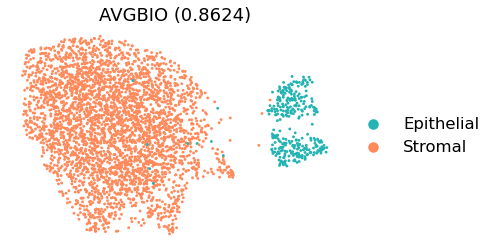

In [ ]:
# UMAP visualization with cell labels
custom_palette = ['#23b3b3', '#ff8a5b', '#6aa84f', '#8e44ad', '#f1c40f']
sc.pl.umap(ref_embed_adata, color=cell_type_col, palette=custom_palette, frameon=False, show=False, wspace=0.4)
plt.title('AVGBIO ({:.04f})'.format(result_dict["avg_bio"]))

Text(0.5, 1.0, 'AVGBATCH (0.8380)')

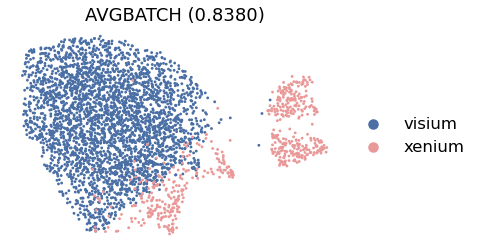

In [ ]:
# UMAP visualization with sequencing protocol labels
custom_palette = ['#4a6fa5', '#ea9999', '#9b6bd3','#52c3a3', '#d8c656',  '#6aa84f']
sc.pl.umap(ref_embed_adata, color='batch_id', palette=custom_palette, frameon=False, show=False, wspace=0.4)
plt.title('AVGBATCH ({:.04f})'.format(result_dict["avg_batch"]))